<a href="https://colab.research.google.com/github/justinfmccarty/urban_bipv_annotated_bib/blob/main/notebooks/bipv_lit_rev_clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Literature Clusters for BIPV

This notebook is a replication of an effort to cluster COVID-19 publications:

Eren, Maksim Ekin, Nick Solovyev, Edward Raff, Charles Nicholas, and Ben Johnson. “COVID-19 Kaggle Literature Organization.” In Proceedings of the ACM Symposium on Document Engineering 2020, 1–4. DocEng ’20. New York, NY, USA: Association for Computing Machinery, 2020. https://doi.org/10.1145/3395027.3419591.

Using the database engine "lens.org" I have extracted building integrated photovoltaic literature to feed into Eren et al.'s clustering workflow.

A future effort will be done once I have access to the Lens API system and can gather a more comprhensive dataset.



### Section 1: Load and Process Data

In [1]:
import pandas as pd
import numpy as np

In [2]:
url = r'https://github.com/justinfmccarty/urban_bipv_annotated_bib/blob/main/data/bipv_inclusive.csv?raw=true'
df_raw = pd.read_csv(url)
df_raw.sample(3)

,Lens ID,Title,Date Published,Publication Year,Publication Type,Source Title,ISSNs,Publisher,Source Country,Author/s,...,Funding,Source URLs,External URL,PMID,DOI,Microsoft Academic ID,PMCID,Citing Patents Count,References,Citing Works Count
6133,069-741-326-733-24X,Nano-enhanced phase change material for therma...,NaN,2017.0,journal article,Applied Energy,03062619,Elsevier BV,United Kingdom,Shivangi Sharma; Leonardo Micheli; Wenlong Cha...,...,Engineering and Physical Science Research Coun...,https://ore.exeter.ac.uk/repository/handle/108...,http://dx.doi.org/10.1016/j.apenergy.2017.09.076,NaN,10.1016/j.apenergy.2017.09.076,2756715500,NaN,0,000-002-115-065-576; 000-716-072-383-99X; 003-...,73
6772,079-571-349-852-579,[특집] 국외 BIPV 지원제도 및 규정 현황 분석,NaN,2013.0,NaN,NaN,NaN,NaN,NaN,null 이병연; null 윤종호,...,NaN,http://www.auric.or.kr/User/Rdoc/DocRdoc.aspx?...,http://www.auric.or.kr/User/Rdoc/DocRdoc.aspx?...,NaN,NaN,2895639445,NaN,0,NaN,0
8471,107-278-155-193-019,3D Modelling Tool to Optimise Advanced Plasmon...,NaN,2019.0,dissertation,NaN,NaN,NaN,NaN,Mehran Rafiee,...,NaN,http://www.tara.tcd.ie/handle/2262/90922,http://www.tara.tcd.ie/handle/2262/90922,NaN,NaN,2995487134,NaN,0,NaN,0


In [3]:
# for this notebook I am only getting journal articles
df_raw_j = df_raw[df_raw['Publication Type']=='journal article']
print(f'Original shape was {df_raw.shape}')
print(f'New shape is {df_raw_j.shape}')

Original shape was (11478, 29)
New shape is (7391, 29)


In [4]:
# remove publications without an abstract as this is key to the clustering effort
df_raw_j_clean = df_raw_j.dropna(subset=['Abstract'])
print(f'Original shape was {df_raw_j.shape}')
print(f'New shape is {df_raw_j_clean.shape}')
df_raw_j_clean.sample(2)

Original shape was (7391, 29)
New shape is (7132, 29)


,Lens ID,Title,Date Published,Publication Year,Publication Type,Source Title,ISSNs,Publisher,Source Country,Author/s,...,Funding,Source URLs,External URL,PMID,DOI,Microsoft Academic ID,PMCID,Citing Patents Count,References,Citing Works Count
3037,030-832-963-463-690,Industrial multi-energy and production managem...,2018-11-02,2018.0,journal article,IET Cyber-Physical Systems: Theory & Applications,23983396,Institution of Engineering and Technology (IET),NaN,Wei Pei; Xin Ma; Wei Deng; Xinhe Chen; Hongjia...,...,National Key Research and Development Program ...,https://ietresearch.onlinelibrary.wiley.com/do...,http://dx.doi.org/10.1049/iet-cps.2018.5029,NaN,10.1049/iet-cps.2018.5029,2894831379,NaN,0,002-699-301-368-226; 012-634-725-343-896; 016-...,3
2970,030-095-596-947-847,Applications of machine learning methods to id...,NaN,2016.0,journal article,Energy and Buildings,03787788,Elsevier BV,Netherlands,Daniel E. Marasco; Constantine E. Kontokosta,...,NaN,http://www.sciencedirect.com/science/article/p...,http://dx.doi.org/10.1016/j.enbuild.2016.06.092,NaN,10.1016/j.enbuild.2016.06.092,2460994027,NaN,0,003-358-791-320-09X; 009-399-926-167-221; 010-...,37


In [5]:
# there may be a need for publication year later on in visualization 
# so I will be dropping anything without a publication year

# lets see how many
print(f"Missing in Publication Year {len(df_raw_j_clean[df_raw_j_clean['Publication Year'].isnull()])}")
print(f"Missing in Date Published {len(df_raw_j_clean[df_raw_j_clean['Date Published'].isnull()])}")

df_raw_j_clean_years = df_raw_j_clean.dropna(subset=['Publication Year'])
print(f'Original shape was {df_raw_j_clean.shape}')
print(f'New shape is {df_raw_j_clean_years.shape}')

Missing in Publication Year 27
Missing in Date Published 4033
Original shape was (7132, 29)
New shape is (7105, 29)


In [6]:
# simplify dataframe for clustering workflow

columns = ['Lens ID',
           'Title',
           'Publication Year',
           'Abstract',
           'External URL',
           'DOI',
           'Author/s']

df_raw_j_clean_sub = df_raw_j_clean_years[columns].astype({'Publication Year':'int32'})
df_raw_j_clean_sub = df_raw_j_clean_sub.rename(columns={'Lens ID':'lens_id',
                                                        'Title':'title',
                                                        'Publication Year':'year',
                                                        'Abstract':'abstract',
                                                        'External URL':'external_url',
                                                        'DOI':'doi',
                                                        'Author/s':'authors'})

df_raw_j_clean_sub.sample(3)


,lens_id,title,year,abstract,external_url,doi,authors
6266,071-752-862-756-272,Electric Vehicle into the Grid: Charging Metho...,2019,The necessity of transport electrification is ...,http://dx.doi.org/10.3390/en12122443,10.3390/en12122443,G. Saldana; José I. Martín; Inmaculada Zamora;...
3781,039-475-263-302-348,Building‐integrated PV activities within the I...,1996,Early in 1997 a new task will be launched with...,http://dx.doi.org/10.1002/(sici)1099-159x(1996...,10.1002/(sici)1099-159x(199607/08)4:4<237::aid...,Tony J. N. Schoen; Heribert Schmidt
1969,019-267-079-613-486,Integrating global energy and climate governan...,2015,Despite the long-recognized interlinkages betw...,http://dx.doi.org/10.1016/j.enpol.2015.09.009,10.1016/j.enpol.2015.09.009,Harald Heubaum; Frank Biermann


In [7]:
# last check for any NaN values
for col in df_raw_j_clean_sub.columns:
  if df_raw_j_clean_sub[col].isnull().values.any():
    print(f'{col} contains NaN values.')
  else:
    pass

external_url contains NaN values.
doi contains NaN values.
authors contains NaN values.


In [8]:
# ok so we may want to link back to papers at the end of this so let's see
# where links are missing

print(f"External URL NaN length is {len(df_raw_j_clean_sub[df_raw_j_clean_sub['external_url'].isnull()])}")
print(f"DOI NaN length is {len(df_raw_j_clean_sub[df_raw_j_clean_sub['doi'].isnull()])}")

External URL NaN length is 14
DOI NaN length is 266


In [9]:
# only several missing so I will leave it now and come back with the API from Lens or Crossref 
# so we have the dataset ready for the clustering workflow

df_raw_j_clean_sub.sample(4)

,lens_id,title,year,abstract,external_url,doi,authors
8094,100-701-635-084-779,The Implications of Mandating Photovoltaics on...,2015,Abstract The transition to near zero energy an...,http://dx.doi.org/10.1016/j.egypro.2015.12.199,10.1016/j.egypro.2015.12.199,Stephen Berry; David Whaley
10753,164-528-895-842-084,Modeling of building integrated low concentrat...,2010,We have developed a transparent photovoltaic d...,http://dx.doi.org/10.1117/12.861524,10.1117/12.861524,Itay Baruchi; Moshe Ben Chorin; Barak Freedman...
4319,045-995-219-582-836,Effect of the Fins Length for the Passive Cool...,2016,A two-dimensional (2D) numerical model was use...,http://dx.doi.org/10.3311/ppme.8571,10.3311/ppme.8571,Taieb Nehari; Mohamed Benlakam; Driss Nehari
7353,088-805-994-013-757,DC Grid for Domestic Electrification,2019,Various statistics indicate that many of the p...,http://dx.doi.org/10.3390/en12112157,10.3390/en12112157,G. Arunkumar; D. Elangovan; P. Sanjeevikumar; ...


### Section 2: Clustering Workflow (Eren et al., 2020)

source: https://github.com/MaksimEkin/arXiv-Literature-Clustering/blob/master/arxiv_clustering.ipynb

#### Part A: Final Cleaning

In [ ]:
%%capture 
# need to install some things if runnning in colab
# !pip install langdetect

In [55]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import multiprocessing
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory
from pprint import pprint
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from multiprocessing import Pool
import string


In [11]:
# This package can cause issues so need to check to make sure the model works
# https://github.com/explosion/spaCy/issues/7453

spacy.load('en_core_web_sm')

In [12]:
# so we can skip the first few cells of the original notebook as they 
# read their data into df from the source json files in the Kaggle data

# We begin with the NLP 

df = df_raw_j_clean_sub.copy()

In [13]:
# this processing was done in the larger COVID work around cell 18:
# https://github.com/MaksimEkin/COVID19-Literature-Clustering/blob/master/COVID19_literature_clustering.ipynb
# it is removing non english publications 

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each abstract
for ii in tqdm(range(0,len(df))):
    # split by space into list, take the first x intex, join with space
    text = df.iloc[ii]['title'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in title...
        except Exception as e:
            
            try:
                # let's try to label it through the title then
                lang = detect(df.iloc[ii]['title'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

100%|██████████| 7105/7105 [00:20<00:00, 349.87it/s]


In [14]:

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 7105

{'af': 2,
 'bg': 1,
 'ca': 20,
 'cy': 1,
 'da': 8,
 'de': 51,
 'en': 6906,
 'es': 21,
 'fi': 1,
 'fr': 5,
 'id': 11,
 'it': 15,
 'ko': 5,
 'lt': 1,
 'nl': 7,
 'no': 6,
 'pl': 2,
 'pt': 21,
 'ro': 8,
 'ru': 2,
 'sl': 2,
 'sv': 2,
 'tl': 3,
 'tr': 2,
 'vi': 2}


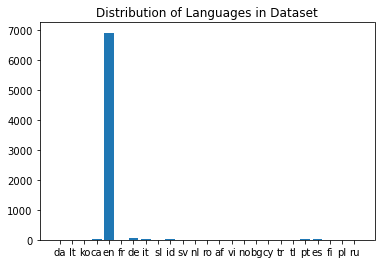

In [15]:

df['language'] = languages
plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
plt.title("Distribution of Languages in Dataset")
plt.show()

In [16]:
# ok so lets get rid of the non-english work
# this is a known issue with this process

df = df[df['language'] == 'en'] 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6906 entries, 0 to 11476
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   lens_id       6906 non-null   object
 1   title         6906 non-null   object
 2   year          6906 non-null   int32 
 3   abstract      6906 non-null   object
 4   external_url  6892 non-null   object
 5   doi           6657 non-null   object
 6   authors       6901 non-null   object
 7   language      6906 non-null   object
dtypes: int32(1), object(7)
memory usage: 458.6+ KB


In [17]:
# back to https://github.com/MaksimEkin/arXiv-Literature-Clustering/blob/master/arxiv_clustering.ipynb
# stop words are common words that may complicate the analysis so we set up 
# a system to remove them


punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[:10]

['anyhow',
 'behind',
 'your',
 'whether',
 'not',
 'bottom',
 'formerly',
 'here',
 'done',
 'n’t']

In [85]:
# also adding in a few more common stop words 
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al',
    'author', 'figure', 'rights', 'reserved', 'permission', 'used', 'using',
    'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 'PMC', 
    'CZI', 'www','abstract', 'Abstract', 'study', 'use'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

In [86]:
# Parser
parser = spacy.load("en_core_web_sm")
parser.max_length = 7000000

def call_tokenizer(df):
    df["processed_abstract"] = df["abstract"].apply(spacy_tokenizer)
    return df

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [87]:
from multiprocessing import get_context

def parallelize_dataframe(df, func, n_cores=4):
    df_split = np.array_split(df, n_cores)
    pool = get_context("fork").Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [88]:

print(multiprocessing.cpu_count()) # Count the number of cores in a computer

8


In [89]:
%time df = parallelize_dataframe(df=df, func=call_tokenizer, n_cores=6)

CPU times: user 44.8 ms, sys: 85.5 ms, total: 130 ms
Wall time: 1min 54s


In [90]:

file_name = "bipv_data.p"
pickle.dump(df, open(file_name, "wb" ))

#### Part B: Clustering

In [91]:

df_new = pickle.load(open(file_name, "rb"))

# next line is if we wanted a subset but this dataframe is small enough
# df_new = df_new.sample(600000)

In [92]:

def vectorize(text, maxx_features):
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

text = df_new['processed_abstract'].values
%time X = vectorize(text, 2 ** 12)
X.shape

CPU times: user 316 ms, sys: 6.68 ms, total: 322 ms
Wall time: 322 ms


(6906, 4096)

In [ ]:
# here we begin the clustering process
# first the PCA for reduction  
# then detect the amount of clusters for k means

# PCA and cluster counts were done in the larger COVID notebook (cell 33)
# https://github.com/MaksimEkin/COVID19-Literature-Clustering/blob/master/COVID19_literature_clustering.ipynb


In [93]:
pca = PCA(n_components=0.95, random_state=42)
%time X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

CPU times: user 4min 37s, sys: 19.7 s, total: 4min 57s
Wall time: 54.4 s


(6906, 2461)

In [140]:
# TODO this needs to be parallelized
# check for amount of clsuters via two methods

distortions = []
sil = []
kmax = 50
K_range = range(2, kmax)
for k in K_range:
    # check k means distortion
    print('----')
    kmeans = KMeans(n_clusters = k,
                  random_state=42).fit(X_reduced)
    distortion_calc = sum(np.min(cdist(X_reduced, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0]
    distortions.append(distortion_calc)
#     print('Found distortion of {} for {} clusters'.format(distortion_calc,k))
    
    # check silhouette score
    labels = kmeans.labels_
    sil_calc = silhouette_score(X_reduced,
                                labels,
                                random_state=42,
                                metric = 'euclidean')
    sil.append(sil_calc)
#     print('Found silhouette score of {} for {} clusters'.format(sil_calc,k))

print('Finished')

----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
----
Finished


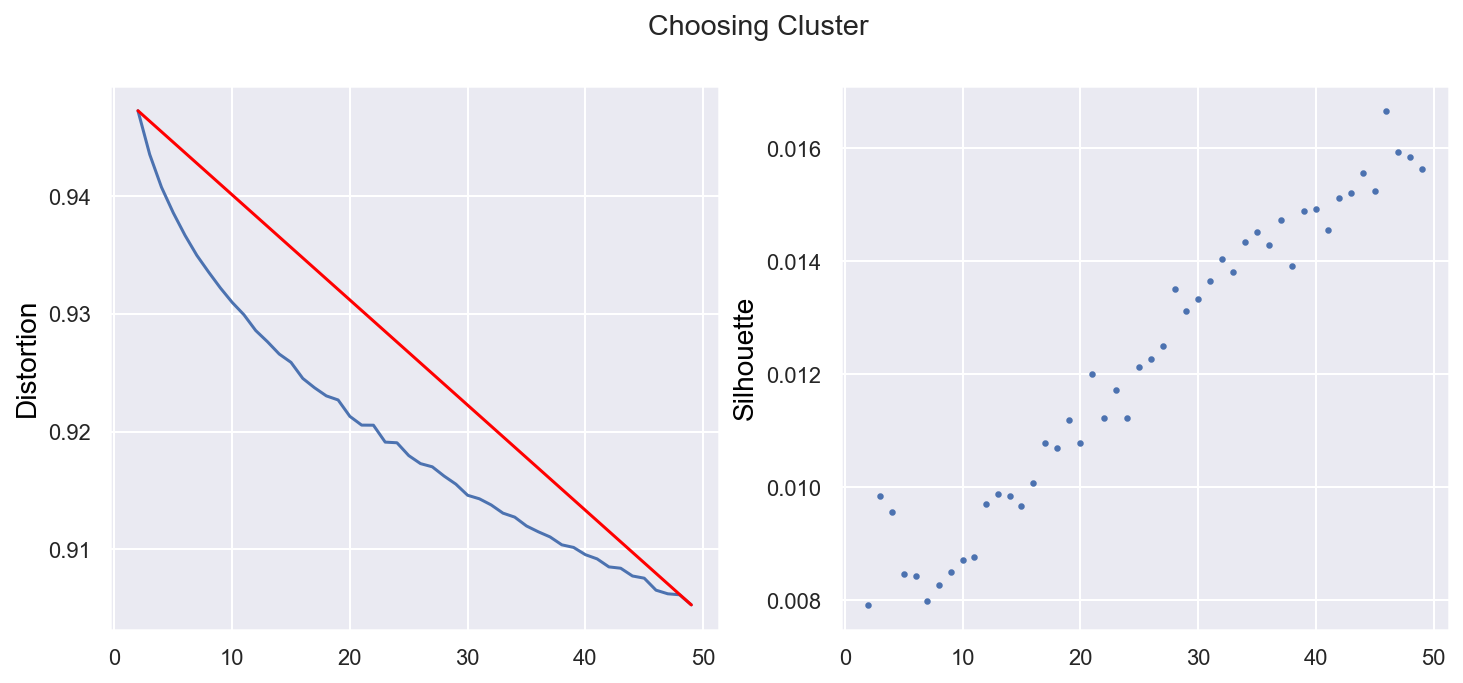

In [141]:
X_line = [K_range[0], K_range[-1]]
Y_distortions = [distortions[0], distortions[-1]]
Y_silhouette = [sil[0], sil[-1]]

# create figure and axis objects with subplots()
fig, axs = plt.subplots(1,2,figsize=(12,5))
fig.suptitle('Choosing Cluster')
axs[0].plot(K_range, distortions, 'b-')
axs[0].plot(X_line, Y_distortions, color="red",)

axs[1].scatter(list(K_range),
               sil,
               s=5)

# set y-axis label
axs[0].set_ylabel("Distortion",color="black",fontsize=14)
axs[1].set_ylabel("Silhouette",color="black",fontsize=14)



# twin object for two different y-axis on the sample plot
# Plot the elbow
ax2.plot(K_range, distortions, 'black')
ax2.plot(X_line, Y_silhouette, 'green')
ax2.set_ylabel("Silhouette",color="blue",fontsize=14)

def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    # https://stackoverflow.com/questions/10481990/matplotlib-axis-with-two-scales-shared-origin
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)

# align_yaxis(ax1, 0, ax2, 0)

ax2.set_ylim(sil[0], sil[-1])


plt.show()
# save the plot as a file
# fig.savefig('two_different_y_axis_for_single_python_plot_with_twinx.jpg',
#             format='jpeg',
#             dpi=100,
#             bbox_inches='tight')

In summary when looking for clusters we see two things. One with the elbow method there is a range around 15 +- 3 in which we may find an optimal amount of clusters. However, the silhouette score makes an assumption that clusters will be of a similar size, which is not applicable to this type of work. Thus we will go with 16.

##### Back to Part B

In [144]:
# looks like the optimal amount of clusters lie around...
clusters = 16

In [145]:

kmeans = KMeans(n_clusters=clusters, random_state=42)
%time y_pred = kmeans.fit_predict(X_reduced)
df_new['y'] = y_pred

CPU times: user 31.8 s, sys: 7.53 s, total: 39.4 s
Wall time: 5.49 s


In [146]:
pickle.dump(df_new, open(f"bipv_data_clusters_{clusters}.p", "wb" ))

In [147]:
# reduce dimensionality with t-SNE
df_new_clustered = pickle.load(open(f'bipv_data_clusters_{clusters}.p', "rb"))


In [148]:

tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 6906 samples in 0.006s...
[t-SNE] Computed neighbors for 6906 samples in 1.860s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6906
[t-SNE] Computed conditional probabilities for sample 2000 / 6906
[t-SNE] Computed conditional probabilities for sample 3000 / 6906
[t-SNE] Computed conditional probabilities for sample 4000 / 6906
[t-SNE] Computed conditional probabilities for sample 5000 / 6906
[t-SNE] Computed conditional probabilities for sample 6000 / 6906
[t-SNE] Computed conditional probabilities for sample 6906 / 6906
[t-SNE] Mean sigma: 0.425727
[t-SNE] KL divergence after 250 iterations with early exaggeration: 125.616158
[t-SNE] KL divergence after 1000 iterations: 3.224323


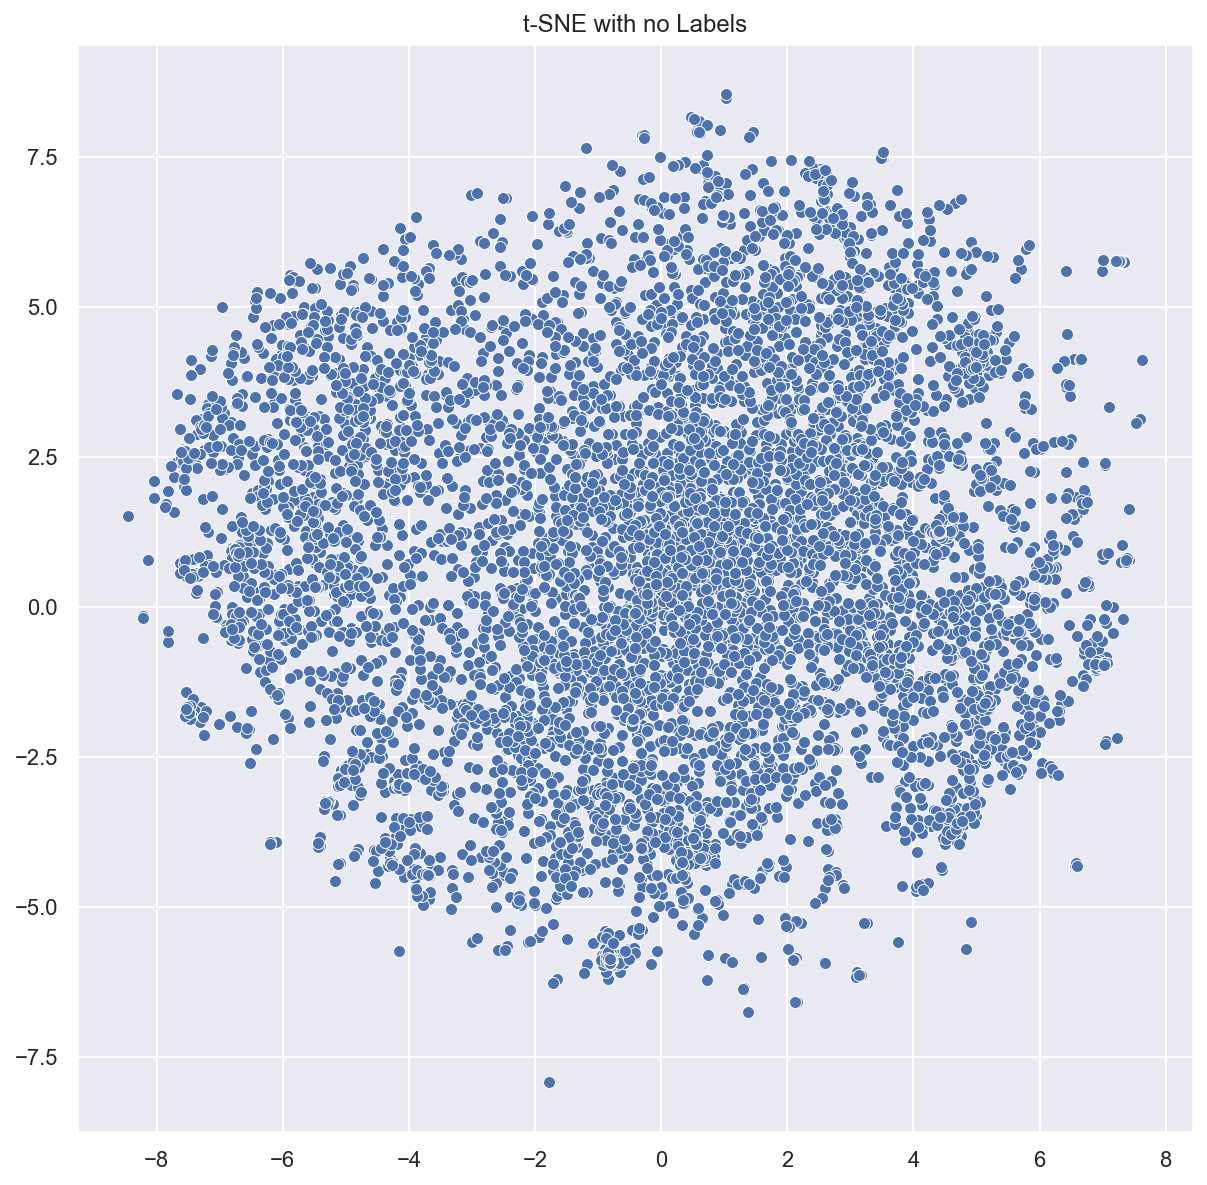

In [149]:

# sns settings
sns.set(rc={'figure.figsize':(10,10)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(x=X_embedded[:,0],
                y=X_embedded[:,1],
                palette=palette)
plt.title('t-SNE with no Labels')
# plt.savefig("tsne_bipv.png")
plt.show()

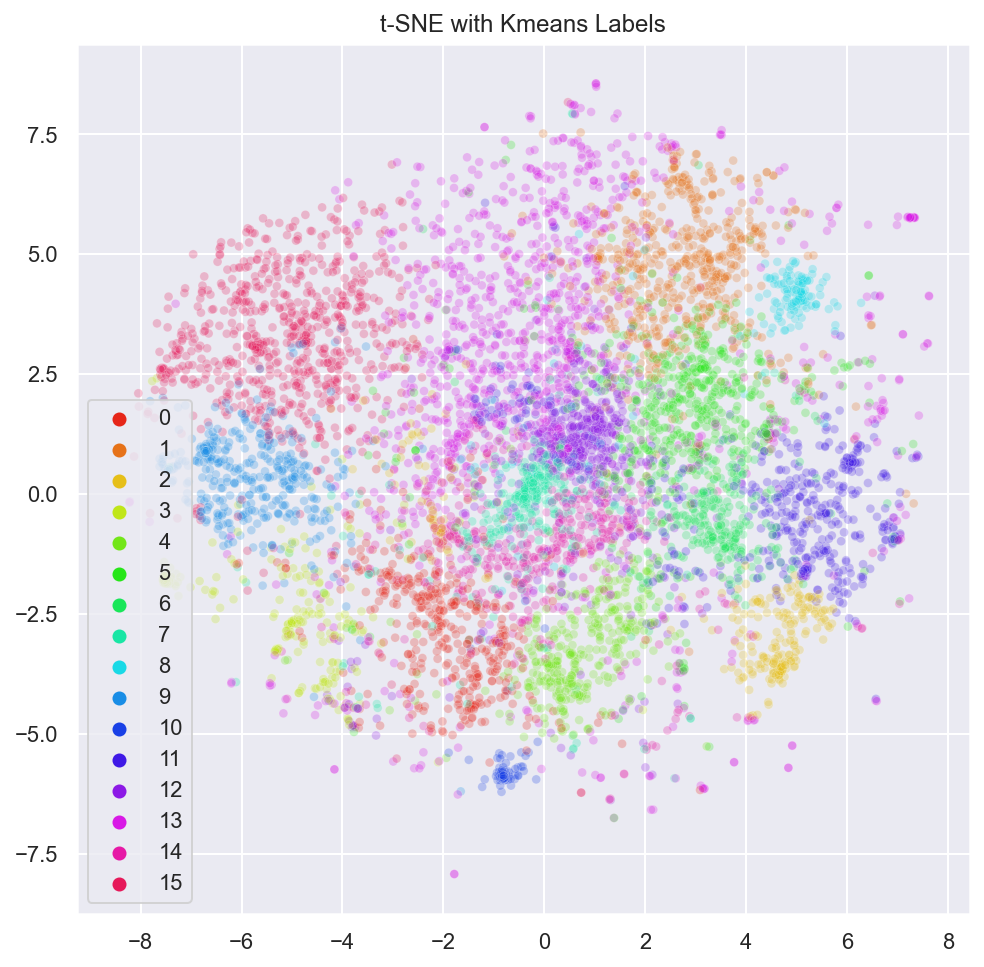

In [162]:

# sns settings
sns.set(rc={'figure.figsize':(8, 8)})

# colors
palette = sns.hls_palette(clusters, l=.5, s=.8)
# palette = sns.color_palette("Paired", as_cmap=True, s=.2)

# plot
sns.scatterplot(x=X_embedded[:,0],
                y=X_embedded[:,1],
                hue=y_pred,
                legend='full',
                palette=palette,
                s=20,
                alpha=0.25
               )
plt.title('t-SNE with Kmeans Labels')
# plt.savefig("tsne_bipv_colored.png")
plt.show()

#### Part C: Labeling

In [58]:
# now we attempt to label each of the clusters using the most common words

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [59]:
vectorizers = []
    
for ii in range(0, clusters):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))
vectorizers[0]

CountVectorizer(max_df=0.9, min_df=5, stop_words='english',
                token_pattern='[a-zA-Z\\-][a-zA-Z\\-]{2,}')

In [60]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(df_new.loc[df_new['y'] == current_cluster, 'processed_abstract']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

len(vectorized_data)

8

In [78]:
NUM_TOPICS_PER_CLUSTER = 15

lda_models = []
for ii in range(0, clusters):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, 
                                    max_iter=10, 
                                    learning_method='online',
                                    verbose=False, 
                                    random_state=42)
    lda_models.append(lda)
    
lda_models[0]

LatentDirichletAllocation(learning_method='online', n_components=15,
                          random_state=42, verbose=False)

In [79]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 3
Current Cluster: 4
Current Cluster: 5
Current Cluster: 6
Current Cluster: 7


In [80]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [81]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 3
Current Cluster: 4
Current Cluster: 5
Current Cluster: 6
Current Cluster: 7


In [1]:
all_keywords[0]


NameError: name 'all_keywords' is not defined

In [69]:
lda_models[0].n_components

TypeError: 'int' object is not callable

In [64]:
# Extracts the keywords from each cluster
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.n_components):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [65]:
# Append list of keywords for a single cluster to 2D list of length NUM_TOPICS_PER_CLUSTER

all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

TypeError: 'int' object is not iterable